<a href="https://colab.research.google.com/github/Carinaaa/ML-Learning-Path/blob/main/PyTorch_classification_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PyTorch** is an open-source machine learning library developed by **Facebook's AI Research lab (FAIR)**. It is widely used for deep learning and artificial intelligence applications, offering strong support for building and training neural networks.

**Key Features:**

*   An optimized tensor library for deep learning using GPUs and CPUs.
*   Dynamic computation graphs, which makes it more flexible and intuitive than static graph frameworks.
* Modules for deep learning, including layers, loss functions, and optimizers.

* TorchScript for model serialization and production deployment.

* Integration with Python, making it easy to debug and prototype.

**Typical Use Cases:**

* Computer vision (e.g., image classification, segmentation)
* Natural language processing (NLP)
* Reinforcement learning
* Scientific computing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Torchvision version 0.21.0+cu124
Numpy version 2.0.2
Pandas version 2.2.2


After importing the modules, let's setup the datasets.

**What are Datasets?**

In machine learning, a dataset is a structured collection of data used for training, validating, and testing models.

A dataset typically includes:

* Input features (e.g., images, text, or tabular data)
* Labels or targets (e.g., categories, values, or sequences)

Datasets are critical because the performance of any machine learning model heavily depends on the quality and diversity of the data it's trained on.

In [ ]:
import kagglehub


# Download latest version
path = kagglehub.dataset_download("ahemateja19bec1025/traffic-sign-dataset-classification")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/traffic-sign-dataset-classification


In [ ]:
import shutil
shutil.copytree('/kaggle', "dataset/kaggle", dirs_exist_ok=True)

'dataset/kaggle'

In [ ]:
class TrafficSignDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [ ]:
train_dataset = TrafficSignDataset(data_dir='/content/dataset/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA')

In [ ]:
len(train_dataset)

4170

In [ ]:
train_dataset[1]

(<PIL.Image.Image image mode=RGB size=165x151>, 0)

Label: 0


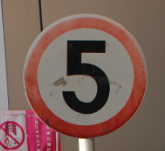

In [ ]:
image, label = train_dataset[1]
print(f"Label: {label}")
image

Label: 3


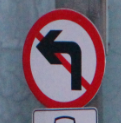

In [ ]:
image, label = train_dataset[299]
print(f"Label: {label}")
image

In [ ]:
# Get a dictionary associating target values with traffic sign names


The dataset should be consistent, so we can use transforms. For example, we can resize the image. We will also transform to a tensor.
Using those transformations we will recreate the dataset.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = '/content/dataset/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA'
train_dataset = TrafficSignDataset(data_dir, transform)

In [ ]:
image, label = train_dataset[100]
image.shape

torch.Size([3, 128, 128])

Larger batch size = faster per-epoch training, but:

* Sometimes slightly worse generalization.

* You may want to tune learning rate proportionally

In [ ]:
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
for images, labels in dataloader:
  break

In [ ]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [ ]:
labels

tensor([29,  8, 55,  1,  3, 23,  9,  8,  0, 54, 45, 30, 23,  6, 12, 50, 12, 21,
        12, 31, 52, 48,  4, 11,  9, 46, 50, 21, 45,  3, 24,  3])

**Typical Flow (Full Pipeline)**

1.   Dataset: load images + YOLO labels ([class, x, y, w, h])
2.   DataLoader: create batches with shuffle=True
3.   Model: define or load a model (YOLO, Faster R-CNN, custom CNN)
4.   Loss Function: compute error between prediction and ground truth
5.   Optimizer: update weights using .backward() and .step()
6.   Train Loop: repeat over epochs, improve predictions

In [ ]:
class SimpleTrafficSignClassifier(nn.Module):
    def __init__(self, num_classes=58):
        super(SimpleTrafficSignClassifier, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

At model definition step, you can either create your own model, defining different kinds of layers or you can import existing models such as fasterrcnn_resnet50_fpn etc.

**Example of simple model:**

    class SimpleCNN(nn.Module):
      def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(16 * 111 * 111, num_classes)  # example size

      def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

In [ ]:
model = SimpleTrafficSignClassifier(num_classes=58)
print(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

SimpleTrafficSignClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
    

In [ ]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 58])

**The training loop**

In [ ]:
# Loss function - This compares the model’s output with the ground truth and returns a loss value for backpropagation.
criterion = nn.CrossEntropyLoss()
# Optimizer - This updates the model's weights using gradients computed during backpropagation.
optimezer = optim.Adam(model.parameters(), lr=0.001) # learning rate is constant in this case

**Setup Datasets**

Note: the test images need to be in their label folder in order to be used with defined classifier.

In [ ]:
import os
import shutil

directory = '/content/dataset/kaggle/input/traffic-sign-dataset-classification/traffic_Data/TEST'

for entry in os.scandir(directory):
  label_name = str(entry.name[1:3])
  print(f"{label_name} is processing...")
  if label_name[0] == '0': # 00, 01, 02, 03...
    label_name = label_name[1]
  try:
    os.mkdir("/content/dataset/kaggle/TEST/" + label_name)
  except FileExistsError:
    print("Exist, only moving files")
  try:
    shutil.move(directory + '/' + entry.name, "/content/dataset/kaggle/TEST/" + label_name)
  except FileNotFoundError:
    print(f"{entry.name} cannot be copied...")

06 is processing...
13 is processing...
57 is processing...
44 is processing...
28 is processing...
05 is processing...
54 is processing...
56 is processing...
03 is processing...
03 is processing...
Exist, only moving files
13 is processing...
Exist, only moving files
05 is processing...
Exist, only moving files
07 is processing...
28 is processing...
Exist, only moving files
35 is processing...
17 is processing...
11 is processing...
04 is processing...
43 is processing...
26 is processing...
39 is processing...
46 is processing...
03 is processing...
Exist, only moving files
17 is processing...
Exist, only moving files
16 is processing...
11 is processing...
Exist, only moving files
12 is processing...
54 is processing...
Exist, only moving files
43 is processing...
Exist, only moving files
56 is processing...
Exist, only moving files
26 is processing...
Exist, only moving files
13 is processing...
Exist, only moving files
39 is processing...
Exist, only moving files
31 is processin

In [ ]:
for i in range(59):
  try:
    os.mkdir("/content/dataset/kaggle/VALID/" + str(i))
  except FileExistsError:
    print("Folder already created")


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '/content/dataset/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA'
valid_folder = '/content/dataset/kaggle/TEST' # Should be VALID the folder, but I did not add all the data in there...
test_folder = '/content/dataset/kaggle/TEST'

train_dataset = TrafficSignDataset(train_folder, transform=transform)
val_dataset = TrafficSignDataset(valid_folder, transform=transform)
test_dataset = TrafficSignDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

**Training loop**

A **classification training loop** is the iterative process by which a model learns to categorize input data into predefined classes. It involves feeding data through the model, computing errors, and updating model weights to reduce those errors.

Model: efficientnet_b0

Loss function: commonly cross-entropy loss for classification.

Optimizer: e.g. SGD or Adam, we used Adam

An **epoch** is one full pass through the training dataset.

The data is divided into **batches** for efficiency.

For each batch:

* Forward Pass: Pass input data through the model to get predictions.

* Loss Calculation: Compare predictions to true labels using the loss function.

* Backward Pass: Compute gradients using backpropagation.

* Optimizer Step: Update model weights using the optimizer.

* (Optional) Track accuracy or other metrics.

After each epoch, evaluate the model on a validation set to monitor generalization.

In [ ]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleTrafficSignClassifier(num_classes=61)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward() # using weights
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/131 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 0.6517239690827523, Validation loss: 6.422434494123535


Training loop:   0%|          | 0/131 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.06933589959762794, Validation loss: 8.23044730062291


Training loop:   0%|          | 0/131 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.0636968119065467, Validation loss: 9.466528299183341


Training loop:   0%|          | 0/131 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.017487248264217405, Validation loss: 9.365322596839103


Training loop:   0%|          | 0/131 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.06879463147514944, Validation loss: 8.768396497251038


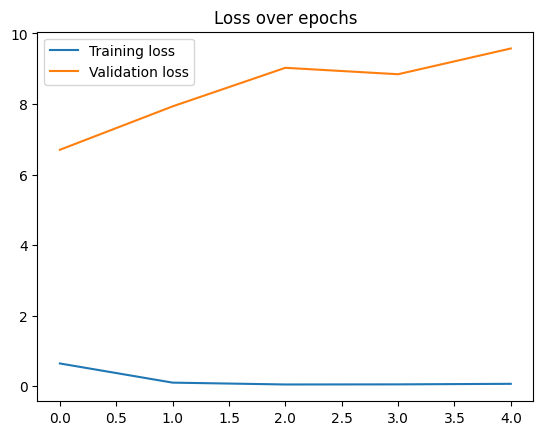

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()


Training loss:

*   is the error calculated on the same data the model is being trained on.
*   used to optimize the model's calculated parameters during the training process, aiming to minimize the value
*   decreseaing values indicate  that the model is learning effectively


Validation loss:

*   is the error calculated on a separated dataset, that the model has not seen during the training
*   decreasing values indicate that the model is generalizing well on unseen data
*   increasing value or plateauing while the training loss decreases, may indicate overfitting

Intrepretation: overfitting, probably due to using validation data from the TEST data (?)

